# Exploration Notebook for Louvain (UCI-ID 50, Image Segmentation)

## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sb
import umap.plot
from community import community_louvain
from ucimlrepo import fetch_ucirepo

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [3]:
import sys

sys.path.append("../")
import visualization
import processing
from embedding_obj import EmbeddingObj

## Workflow Example

In [4]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/186/wine+quality)
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

target_feature = "pH"
labels = pd.Categorical(y["quality"]).codes

X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_5984\3607462673.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


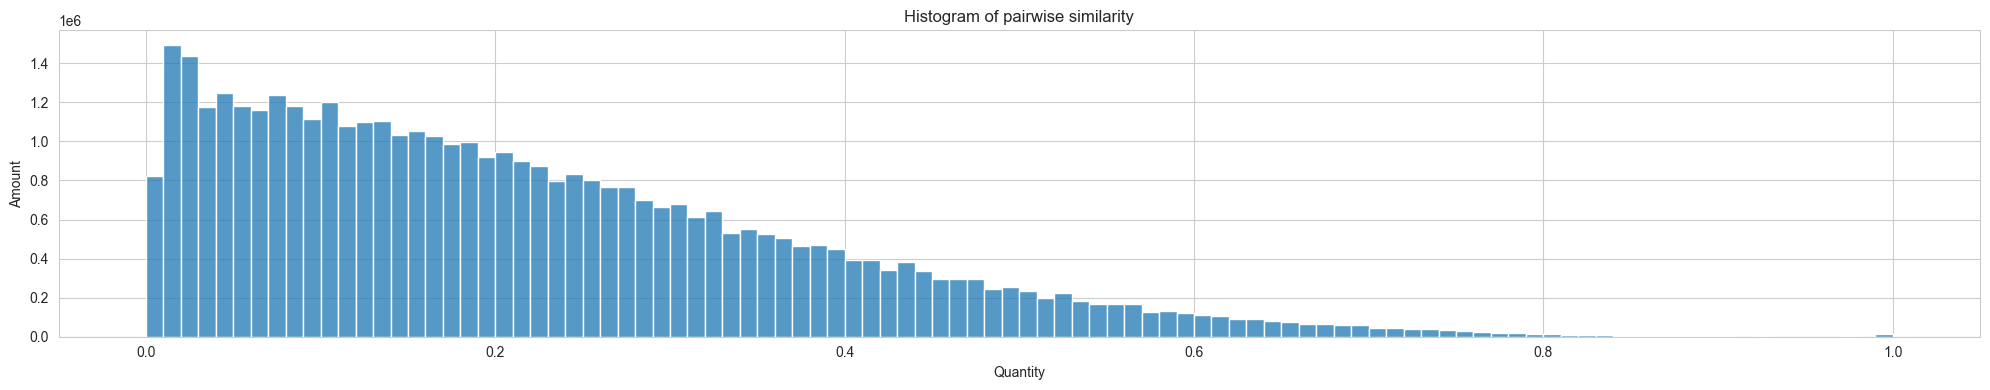

In [5]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])

fig, ax = plt.subplots(figsize=(20, 4))
sb.histplot(connectivity_pairwise.flatten(), bins=100, ax=ax)
ax.set_title("Histogram of pairwise similarity")
ax.set_xlabel("Quantity")
ax.set_ylabel("Amount")

fig.tight_layout()
fig.show()

### 0. Compute initial UMAP-Embedding & Louvain Partition

In [6]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_graph_weights(X, [
    target_feature], n_neighbors=5)

knn_list = [EmbeddingObj(graph=graph_umap_knn, embedding=umap_embedding,
                         edge_weights=edge_weights_umap_knn,
                         title="UMAP-Positions with UMAP-kNN"),
            EmbeddingObj(graph=graph_knn_feat, embedding=umap_embedding,
                         edge_weights=edge_weights_knn_feat,
                         title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'")
            ]

for embedding_obj in knn_list:
    embedding_obj.com_partition = community_louvain.best_partition(
        embedding_obj.sim_graph, random_state=0)

    embedding_obj.labels = embedding_obj.com_partition

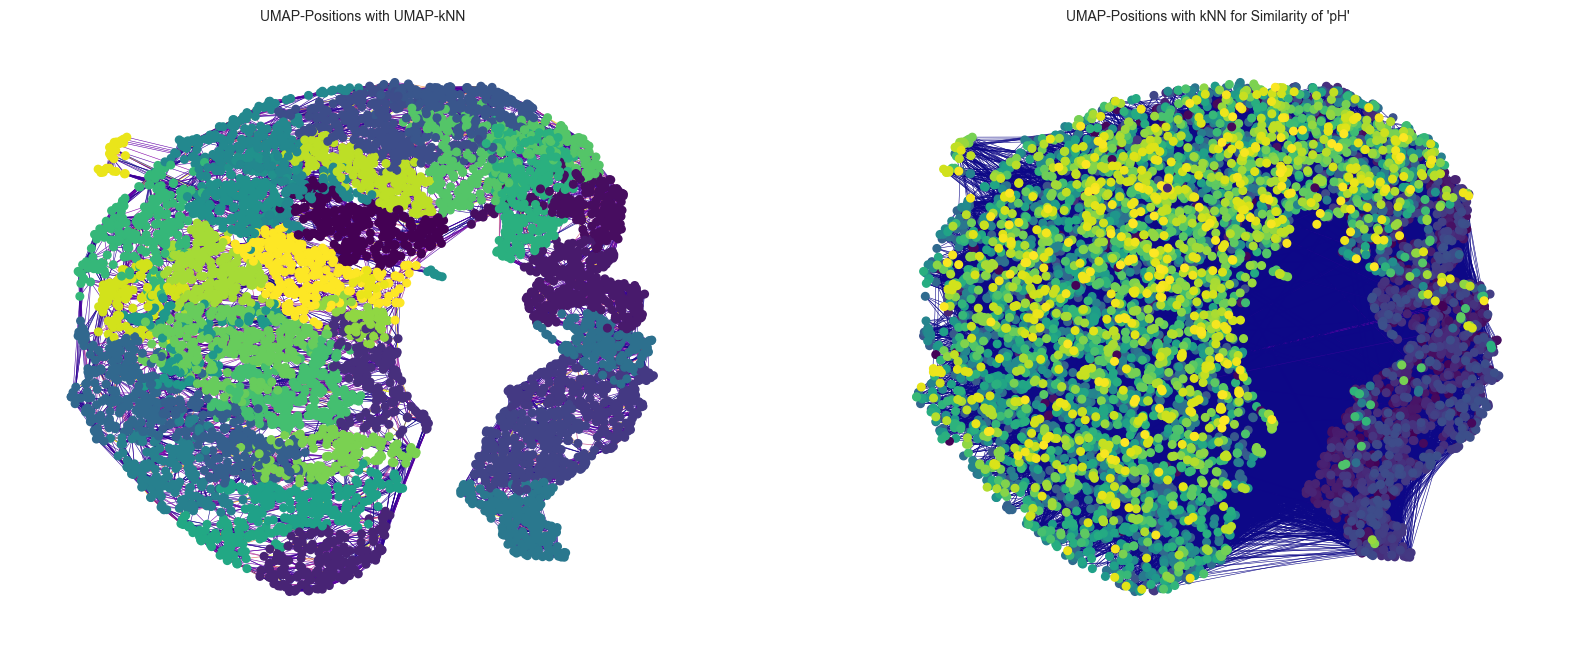

In [8]:
visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 8),
                             cmap='viridis',
                             show_cbar=False)

### 1. Compute modified Embeddings

In [9]:
connectivity_umap_knn_nx = nx.Graph(connectivity_umap_knn)

for u, v in connectivity_umap_knn_nx.edges():
    connectivity_umap_knn_nx[u][v]["weight"] = connectivity_pairwise[u][v]

In [10]:
embeddings = processing.compute_local_force_directed(connectivity_umap_knn_nx,
                                                     umap_embedding,
                                                     [1, 20, 50, 100])

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


In [11]:
embeddings_mst = processing.compute_local_force_directed(connectivity_umap_knn_nx,
                                                         umap_embedding,
                                                         [1, 20, 50, 100], mst=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


In [12]:
embeddings_threshold = processing.compute_local_force_directed(connectivity_umap_knn_nx,
                                                               umap_embedding,
                                                               [1, 20, 50, 100],
                                                               threshold=0.1)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


### 2. Visualize embeddings

In [13]:
partition_values = set(embeddings[0].labels.values())

### 2.1 No MST, no threshold

D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


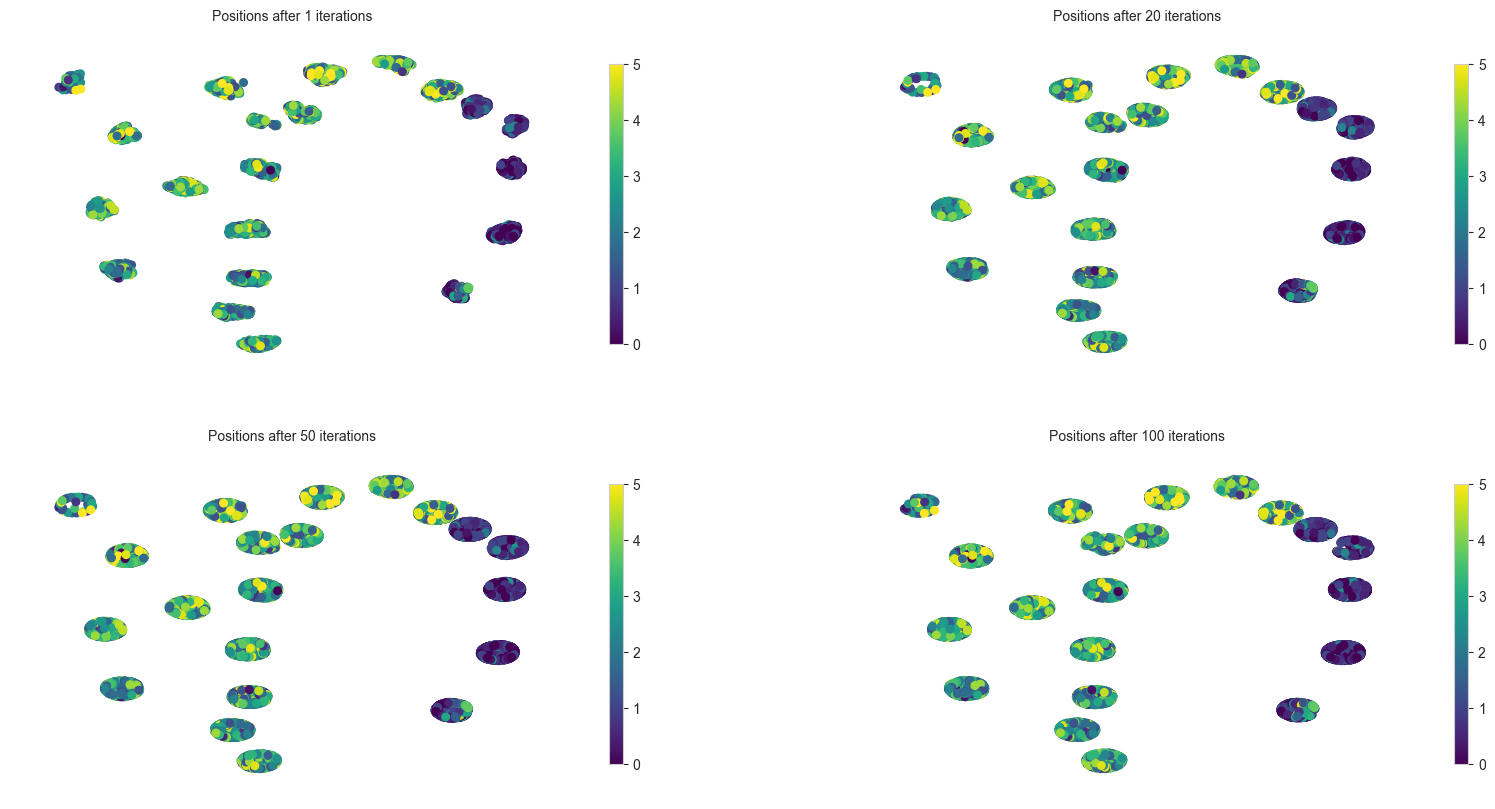

In [14]:
visualization.display_graphs(embeddings,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values)

D:\Software-Projekte\Uni\modDR\src\visualization.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


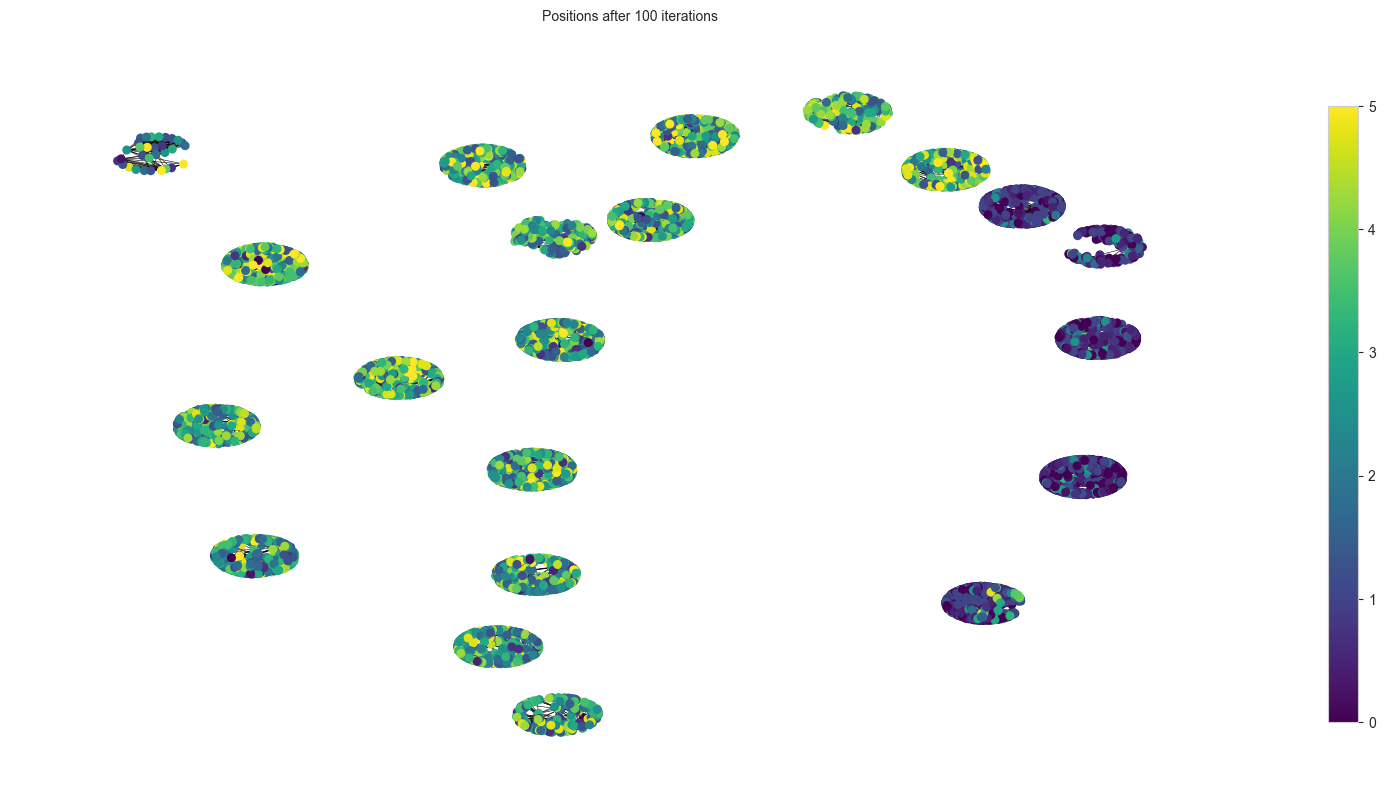

In [15]:
visualization.display_graphs([embeddings[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values)

### 2.3 No MST, threshold at 0.1

D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


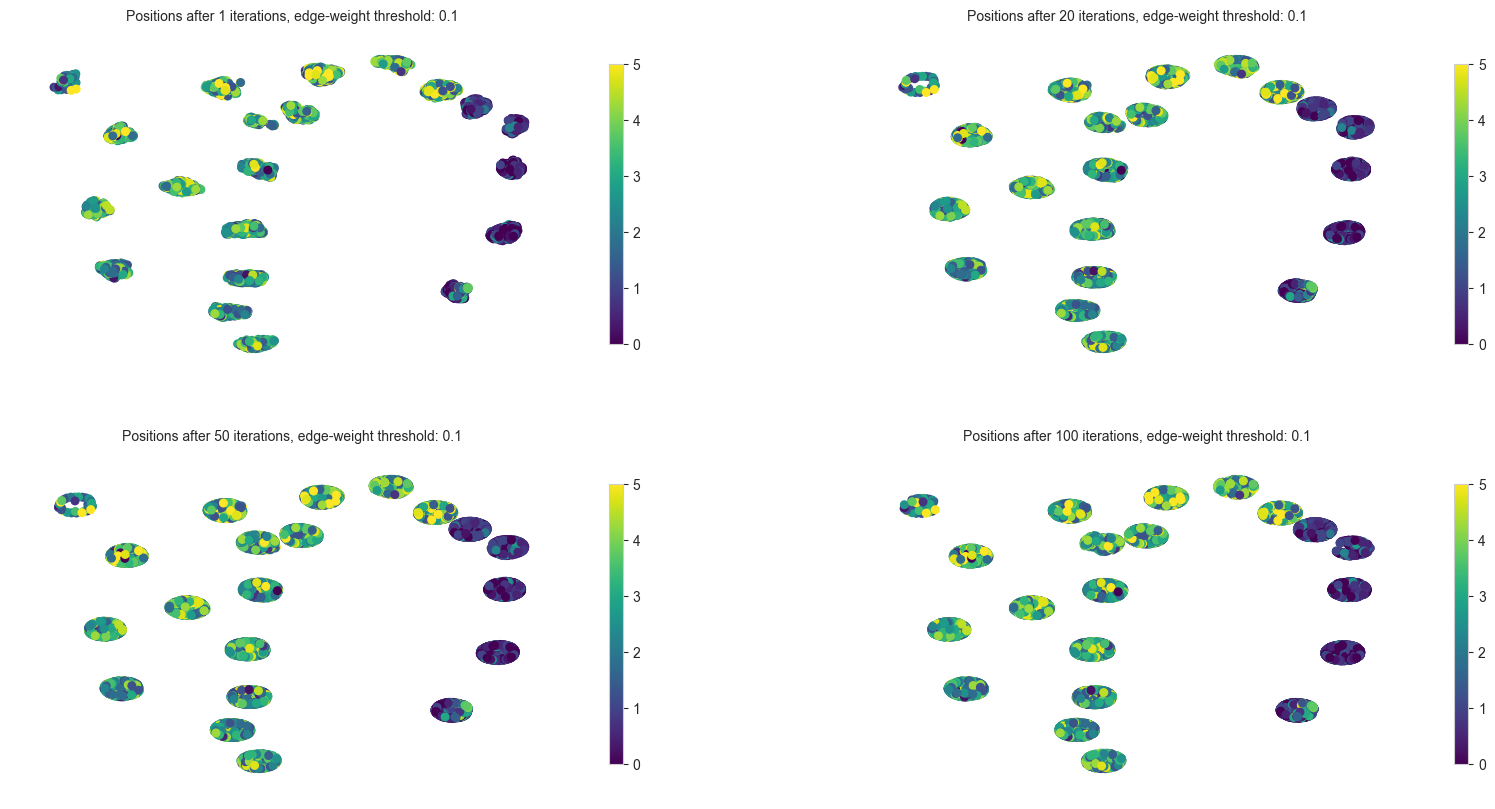

In [16]:
visualization.display_graphs(embeddings_threshold,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values)

D:\Software-Projekte\Uni\modDR\src\visualization.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


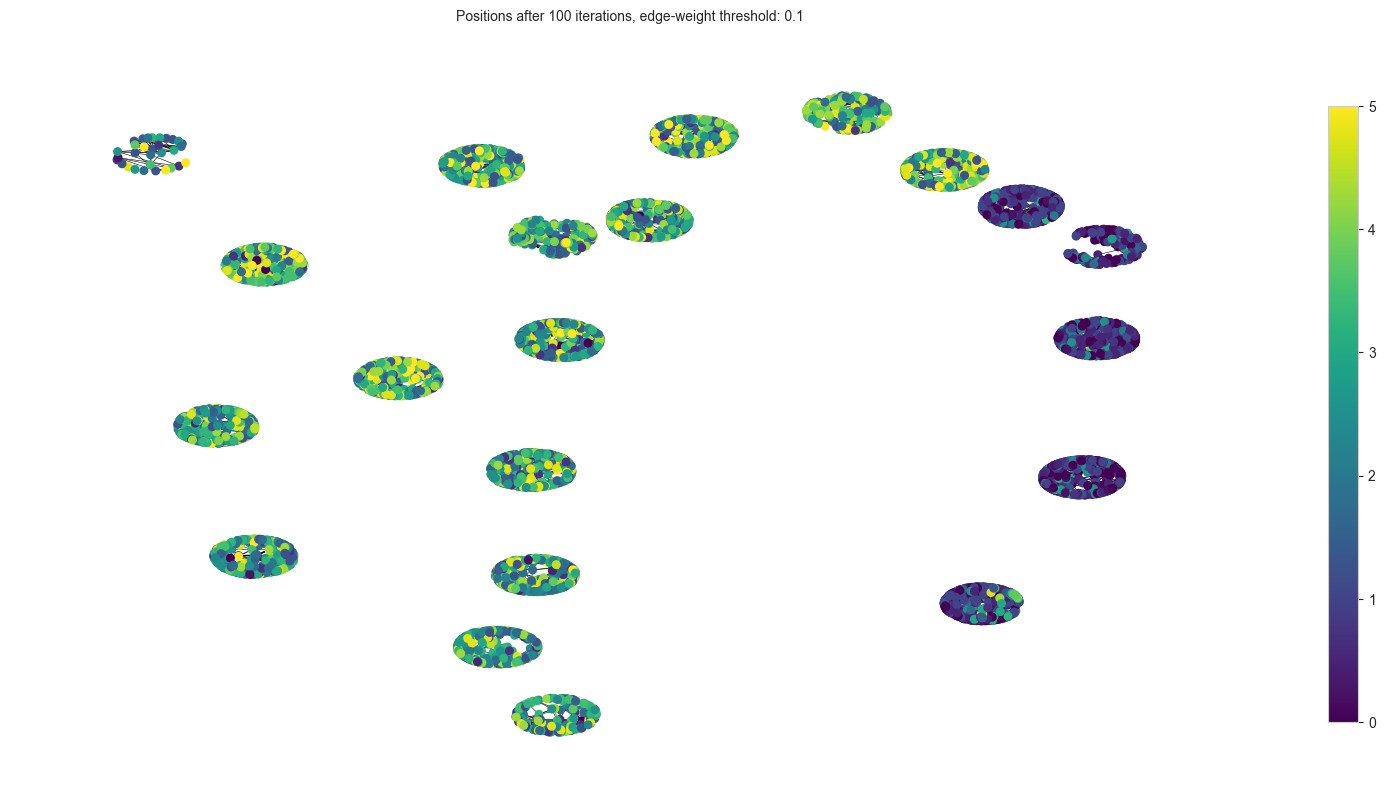

In [17]:
visualization.display_graphs([embeddings_threshold[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values)

### 2.2 MST, no threshold

D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


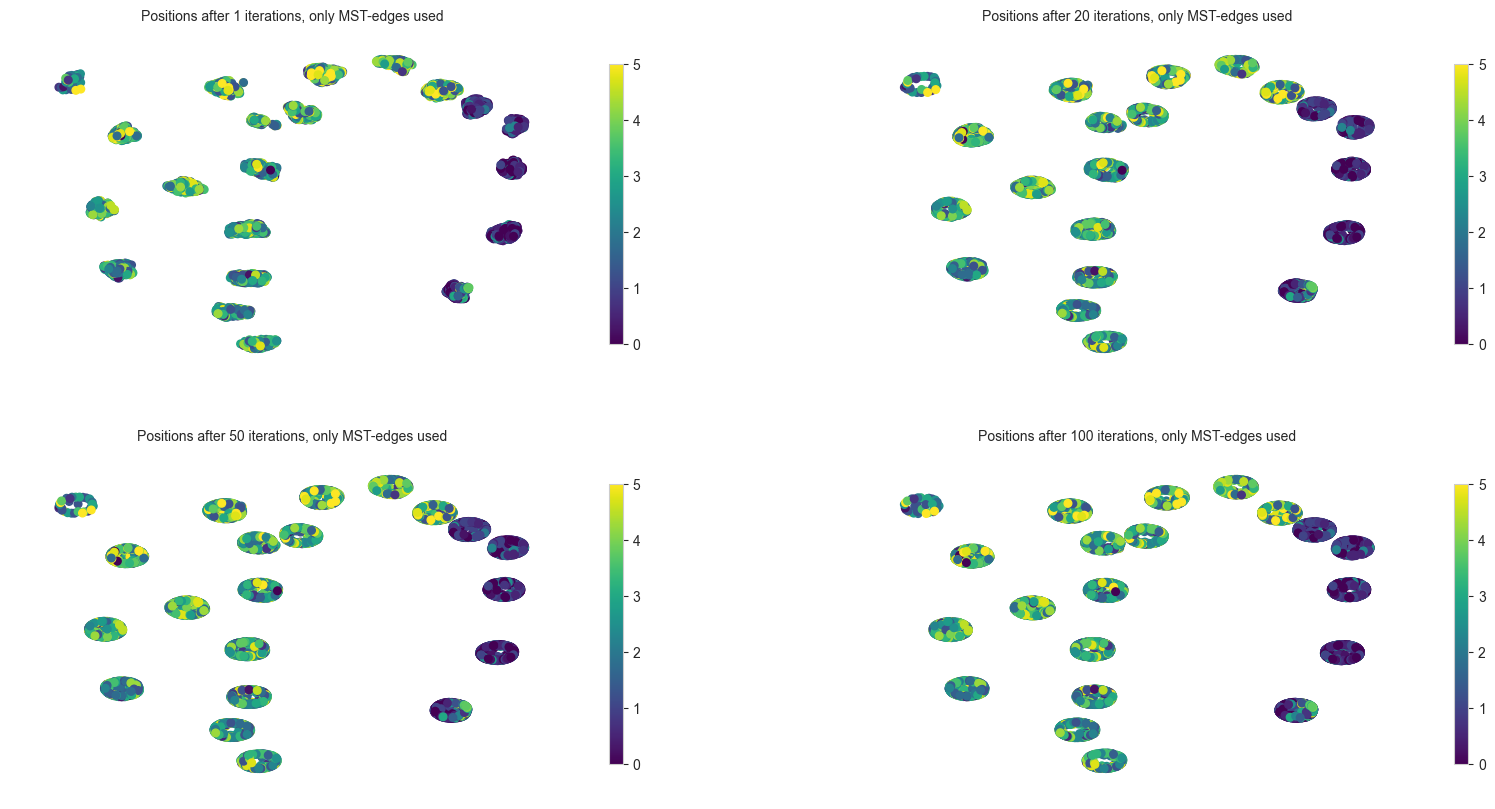

In [18]:
visualization.display_graphs(embeddings_mst,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values)

D:\Software-Projekte\Uni\modDR\src\visualization.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


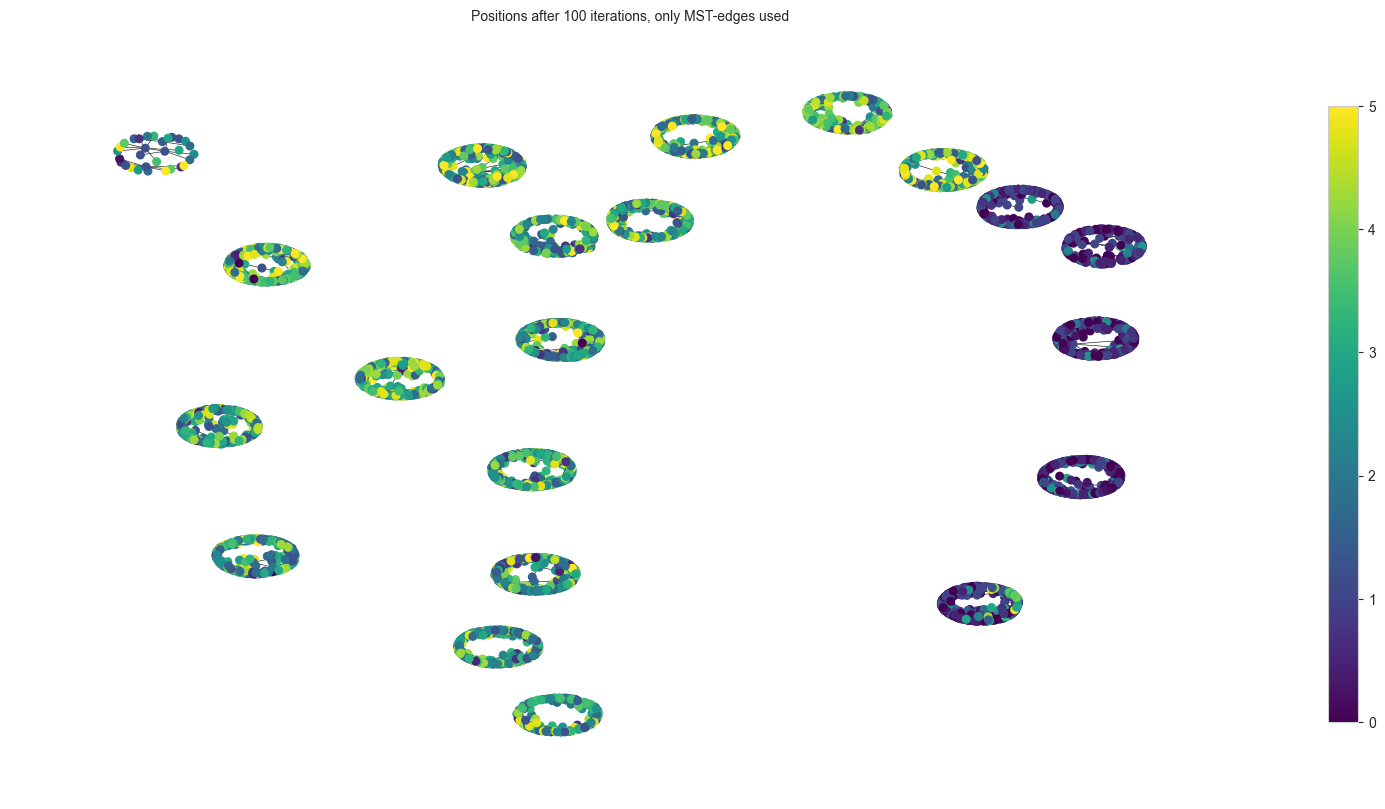

In [19]:
visualization.display_graphs([embeddings_mst[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values)